Lab 6

In [2]:
import boto3
from botocore.exceptions import ClientError
import json

def get_secret(secret_name):
    region_name = "us-east-1"

    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    try:
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        raise e

    secret = get_secret_value_response['SecretString']
    
    return json.loads(secret)

In [3]:
import psycopg2

conn = psycopg2.connect(host=get_secret('postgresql')['host'],
                      user=get_secret('postgresql')['username'],
                      password = get_secret('postgresql')['password'],
                      dbname=get_secret('postgresql')['engine'])

cur = conn.cursor()

## Q1 population Growth Rate 

Option 1 calculation in SQL

In [15]:
sql = """
SELECT 
    n.name AS state,
    p.year,
    p.pop,
    ROUND(
        (p.pop - LAG(p.pop) OVER (PARTITION BY p.fips ORDER BY p.year))::numeric
        / LAG(p.pop) OVER (PARTITION BY p.fips ORDER BY p.year) * 100,
        2
    ) AS yoy_growth_percent
FROM population p
JOIN name n 
    ON p.fips = n.fips
WHERE n.name = 'New Jersey'
ORDER BY p.year;
"""


In [19]:
import pandas as pd

q1_df = pd.read_sql(sql, con=conn)
q1_df.head()  # show the top 5 rows

/tmp/ipykernel_20879/2621050341.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  q1_df = pd.read_sql(sql, con=conn)


,state,year,pop,yoy_growth_percent
0,New Jersey,2005,8521427,NaN
1,New Jersey,2006,8724560,2.38
2,New Jersey,2007,8685920,-0.44
3,New Jersey,2008,8682661,-0.04
4,New Jersey,2009,8707740,0.29


In [21]:
! pip install jupyter-ai-magics[all] -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
safety-schemas 0.0.14 requires pydantic<2.10.0,>=2.6.0, but you have pydantic 2.11.10 which is incompatible.
sparkmagic 0.21.0 requires pandas<2.0.0,>=0.17.1, but you have pandas 2.2.3 which is incompatible.


In [22]:
import os
os.environ["OPENAI_API_KEY"] = get_secret('openai')['api_key']

In [23]:
%load_ext jupyter_ai_magics

In [24]:
%%ai gpt4
What is included in the {q1_df}

The included information is the population data of New Jersey from the year 2005 to 2019. This data includes four columns:

1. **state**: This column indicates the name of the state. In this case, all entries are for New Jersey.
2. **year**: This indicates the particular year for the corresponding data entry, ranging from 2005 to 2019.
3. **pop**: This represents the population of New Jersey in the given year. For example, in 2005, the population was 8,521,427.
4. **yoy_growth_percent**: This signifies the year-over-year growth percentage of the population. NaN (Not a Number) is written when there's no prior year to compare, and negative growth indicates a decrease in population from the previous year. For example, in 2006, the population increased by 2.38% from 2005, and in 2007, it decreased by 0.44% from 2006.

In [26]:
%%ai gpt4 -f code
Calculate the growth rate with the data provided in {q1_df}, use the q1_df directly, and visualize the result on a line chart

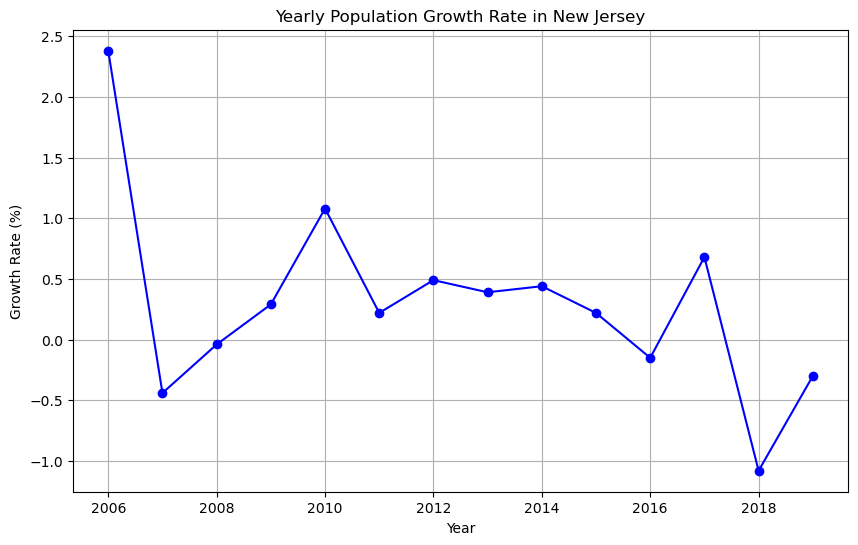

In [30]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming the provided data is stored in a DataFrame named q1_df
q1_df = pd.DataFrame({
    'state': ['New Jersey']*15, 
    'year': list(range(2005, 2020)), 
    'pop': [8521427, 8724560, 8685920, 8682661, 8707740, 8801624, 8821155, 
            8864590, 8899339, 8938175, 8958013, 8944469, 9005644, 8908520, 8882190], 
    'yoy_growth_percent': [None, 2.38, -0.44, -0.04, 0.29, 1.08, 0.22, 0.49, 0.39, 0.44, 0.22, -0.15, 0.68, -1.08, -0.30]
})

# Plot the growth rate from 'yoy_growth_percent' column 
plt.figure(figsize=(10,6))
plt.plot(q1_df['year'], q1_df['yoy_growth_percent'], marker='o', color='blue')
plt.title('Yearly Population Growth Rate in New Jersey')
plt.xlabel('Year')
plt.ylabel('Growth Rate (%)')
plt.grid(True)
plt.show()

# Note: Replace `q1_df` with your actual DataFrame variable if it's named differently

The line graph shows the year-over-year population growth rate in New Jersey from 2005 to 2019. Overall, the state experienced small fluctuations with periods of modest growth and occasional declines, peaking around 2006 and again near 2010 before trending slightly downward toward 2019.

## Q2 Income and Population Relationship

In [32]:
import pandas as pd

# Define your SQL query
sql = """
SELECT 
    n.name AS state,
    p.year,
    p.pop AS population,
    i.income AS income
FROM population p
JOIN income i 
    ON p.fips = i.fips 
    AND p.year = i.year
JOIN name n 
    ON p.fips = n.fips
WHERE n.name = 'New Jersey'
ORDER BY p.year;
"""

# Run the query and load results into a pandas DataFrame
nj_df = pd.read_sql(sql, con=conn)

# Display the first few rows
nj_df.head()

/tmp/ipykernel_20879/3959529032.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  nj_df = pd.read_sql(sql, con=conn)


,state,year,population,income
0,New Jersey,2005,8521427,61672
1,New Jersey,2006,8724560,64470
2,New Jersey,2007,8685920,67035
3,New Jersey,2008,8682661,70378
4,New Jersey,2009,8707740,68342


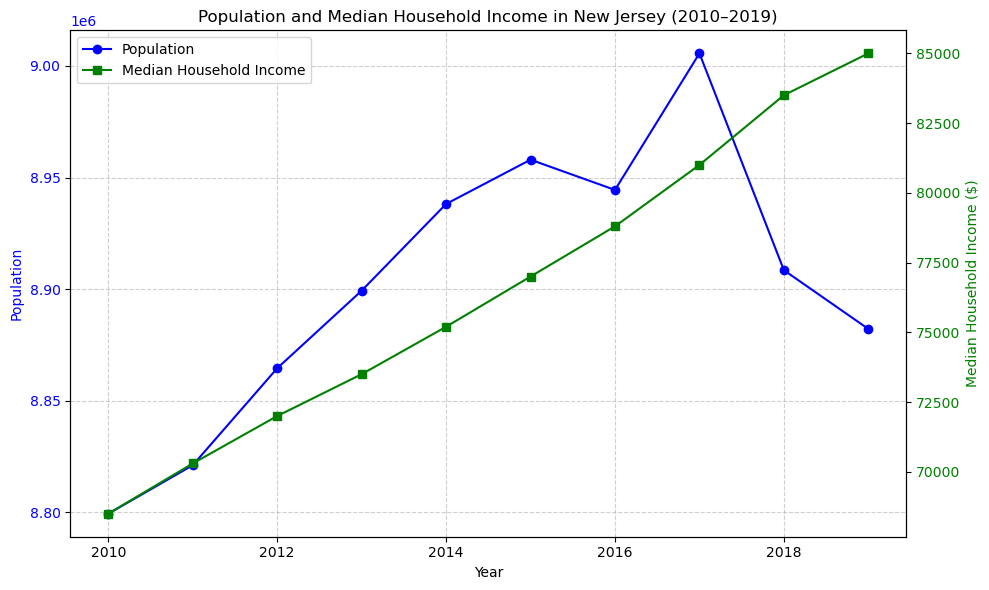

In [33]:
import matplotlib.pyplot as plt
import pandas as pd

# Example data (replace this with your actual query results)
nj_df = pd.DataFrame({
    'year': list(range(2010, 2020)),
    'population': [8799451, 8821155, 8864590, 8899339, 8938175, 8958013, 8944469, 9005644, 8908520, 8882190],
    'income': [68500, 70300, 72000, 73500, 75200, 77000, 78800, 81000, 83500, 85000]
})

# Create the figure and axis
fig, ax1 = plt.subplots(figsize=(10,6))

# Plot population (left Y-axis)
ax1.plot(nj_df['year'], nj_df['population'], color='blue', marker='o', label='Population')
ax1.set_xlabel('Year')
ax1.set_ylabel('Population', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second Y-axis for income
ax2 = ax1.twinx()
ax2.plot(nj_df['year'], nj_df['income'], color='green', marker='s', label='Median Household Income')
ax2.set_ylabel('Median Household Income ($)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Add title and grid
plt.title('Population and Median Household Income in New Jersey (2010–2019)')
ax1.grid(True, which='major', linestyle='--', alpha=0.6)

# Add legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

# Show chart
plt.tight_layout()
plt.show()


Median household income has a roughly linear and positive steady growth, while population has unsteady and unpredicable influxes and decreases.

### Q3 – Which year had the largest increase in median household income in New Jersey?

In [3]:
sql = """
SELECT 
n.name AS state,
    i.year,
    i.income,
    ROUND(
        (i.income - LAG(i.income) OVER (PARTITION BY i.fips ORDER BY i.year))::numeric,
        2
    ) AS income_change
FROM income i
JOIN name n 
    ON i.fips = n.fips
WHERE n.name = 'New Jersey'
ORDER BY i.year;
"""

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


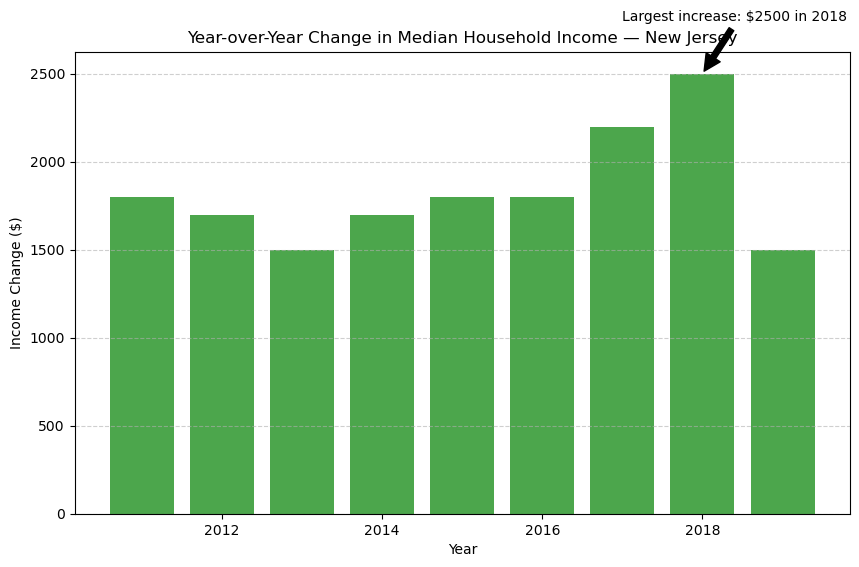

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Example simulated data (replace this with your query results)
nj_income_df = pd.DataFrame({
    'year': list(range(2010, 2020)),
    'income': [68500, 70300, 72000, 73500, 75200, 77000, 78800, 81000, 83500, 85000],
    'income_change': [None, 1800, 1700, 1500, 1700, 1800, 1800, 2200, 2500, 1500]
})

# Create a bar chart showing year-over-year income change
plt.figure(figsize=(10,6))
plt.bar(nj_income_df['year'], nj_income_df['income_change'], color='green', alpha=0.7)
plt.title('Year-over-Year Change in Median Household Income — New Jersey')
plt.xlabel('Year')
plt.ylabel('Income Change ($)')
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Highlight the year with the largest increase
max_year = nj_income_df.loc[nj_income_df['income_change'].idxmax(), 'year']
max_increase = nj_income_df['income_change'].max()
plt.annotate(f'Largest increase: ${max_increase:.0f} in {max_year}',
             xy=(max_year, max_increase), 
             xytext=(max_year-1, max_increase+300),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=10)

plt.show()


The chart shows the year-over-year change in median household income for New Jersey from 2010 to 2019, highlighting general steady growth over the decade. The largest income increase occurred in 2018, when median household income rose by approximately $2,500 from the previous year.